### SST and Heat Flux compare DePreSys4 vs ECMWF Reanalysis

Here, we compare the area-weighted mean SST, surface heat flux anomalies in two experiments. This is to analyse how well DePreSys4 runs perform.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

#### Mean model drift in surface properties

In [2]:
ppdir1="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_2016_DCPP/"

var_list = ['hfds', 'tos', 'sos']

ds_drift = []

for var in var_list:
    
    ds = []
    
    for lead_year in range(0, 11):

        ds1 =[]

        for r in range(1,11):

            d = xr.open_dataset(ppdir1 + "Drift_" + var + "_r" + str(r) + "_Lead_Year_" + 
                                str(lead_year + 1) + ".nc", decode_times= False)
            ds1.append(d)

        ds1 = xr.concat(ds1, dim='r')

        ds.append(ds1)

    ds = xr.concat(ds, dim='lead_year')
    
    ds_drift.append(ds)
    
ds_drift = xr.merge(ds_drift)

ds_mask = xr.open_dataset('/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_Regions.nc')
ds_area = xr.open_dataset('/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Area.nc')
ds_mask['area'] = ds_area['area_t'].rename({'x':'i', 'y':'j'})

ds_drift = xr.merge([ds_drift, ds_mask])

print(ds_drift)

<xarray.Dataset>
Dimensions:         (i: 450, j: 450, lead_year: 11, r: 10)
Coordinates:
  * i               (i) int32 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    longitude       (j, i) float32 -99.75 -99.5 -99.25 ... 51.08 51.24 51.41
    latitude        (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
  * j               (j) int32 699 700 701 702 703 ... 1144 1145 1146 1147 1148
    nav_lat         (j, i) float32 ...
    nav_lon         (j, i) float32 ...
Dimensions without coordinates: lead_year, r
Data variables:
    hfds            (lead_year, r, j, i) float32 59.79 59.89 ... -277.8 -194.2
    tos             (lead_year, r, j, i) float32 27.35 27.36 ... -0.7296 -1.264
    sos             (lead_year, r, j, i) float32 33.46 33.45 ... 34.32 34.17
    mask_regions    (j, i) float64 ...
    mask_North_Atl  (j, i) float64 ...
    area            (j, i) float32 ...


In [3]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.LAND)
    ax.set_aspect(1.0)
    
    _ = plt.title(title, fontsize=14)
    return fig

In [4]:
def Compute_area_weighted_mean(ds, area, mask, mask_val): 
    
    tmp = ds.where(mask == mask_val)
    dA = area.where(mask == mask_val)
    
    tmp1 = (tmp * dA).sum(['i', 'j']) / dA.sum(['i', 'j']) 
    
    return tmp1

Drift_mean = xr.Dataset()

for var in var_list:
    
    area_weigh_val = Compute_area_weighted_mean(ds_drift[var], 
                                                ds_drift['area'], ds_drift['mask_North_Atl'], 0.)
    
    Drift_mean[var] = area_weigh_val.compute()

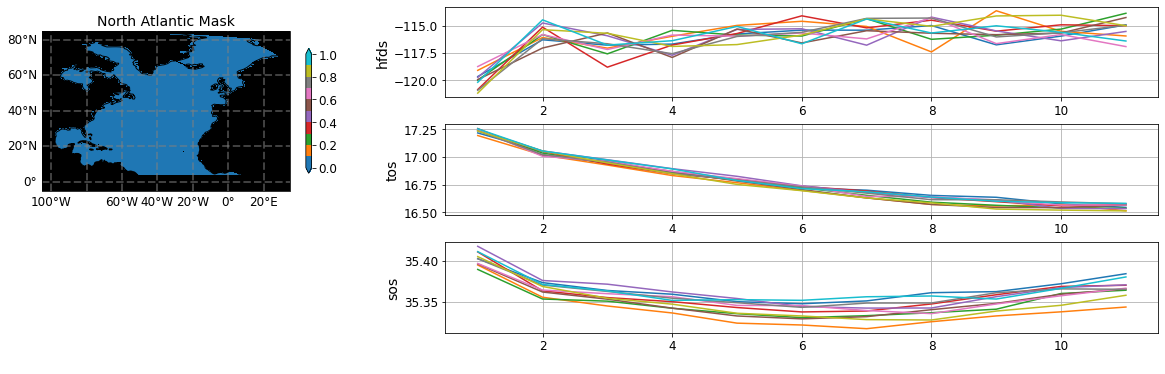

In [5]:
# PLot mean model drift

lat_lon_ext = [-105., 35., -5., 85.]
grid1 = plt.GridSpec(3, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[20,6])
    
ax = fig.add_subplot(grid1[0:2, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = ds_drift['mask_North_Atl'].where(ds_drift['mask_North_Atl']==0.)
p = plot_sec(ax, tmp, vmin=0., vmax=1., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='tab10', title=r'North Atlantic Mask')

i = 0
for var in var_list:
    ax = fig.add_subplot(grid1[i, 1:3])
    for r in range(0,10):
        ax.plot(Drift_mean['lead_year'] + 1, Drift_mean[var].isel(r=r))
    ax.set_ylabel(var, fontsize=14)
    ax.set_xlabel(' ')
    ax.grid('on')
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    i = i + 1

#### Surface anomalies in ECMWF reanalysis product 

In [6]:
var_list1 = ['sohefldo', 'sosstsst', 'sosaline']

ppdir="/home/users/hkhatri/DePreSys4_Data/"

ds_ECMWF = []

for var in var_list1:
    
    d = xr.open_dataset(ppdir + "Data_Anomaly_Reanalysis_ECMWF/" + var + ".nc")
    
    ds_ECMWF.append(d)

ds_ECMWF = xr.concat(ds_ECMWF, dim='var')

ds_DePreSys = []

var_list2 = ['hfds', 'tos', 'sos']

for var in var_list2:
    
    ds = []
    
    for i in range(0,9):
    
        d = xr.open_dataset(ppdir + "Data_Anomaly_Compute/Anomaly_" + var + "_r" + str(i+1) + ".nc")
        
        ds.append(d)
    
    ds = xr.concat(ds, dim='r')
    
    ds_DePreSys.append(ds)

ds_DePreSys = xr.concat(ds_DePreSys, dim='var')

print(ds_ECMWF, ds_DePreSys)

<xarray.Dataset>
Dimensions:            (time_counter: 149, var: 3, r: 5)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
    season             (time_counter) object 'DJF' 'MAM' 'JJA' ... 'SON' 'DJF'
    time               float64 0.0
Dimensions without coordinates: var, r
Data variables:
    Labrador_Sea       (var, time_counter, r) float64 -32.35 -2.432 ... -0.05064
    Irminger_Sea       (var, time_counter, r) float64 23.07 15.09 ... -0.07158
    Iceland_Basin      (var, time_counter, r) float64 86.42 30.73 ... -0.1377
    North_East_Region  (var, time_counter, r) float64 33.32 14.87 ... -0.0477
    South_West_Region  (var, time_counter, r) float64 -61.78 -2.253 ... -0.02635
    South_East_Region  (var, time_counter, r) float64 -4.947 -4.803 ... -0.09875
    North_Atlantic     (var, time_counter, r) float64 2.361 5.146 ... 0.04289 <xarray.Dataset>
Dimensions:            (var: 3, r: 9, start_year: 57, lead_year: 11)
Dimensions without coor

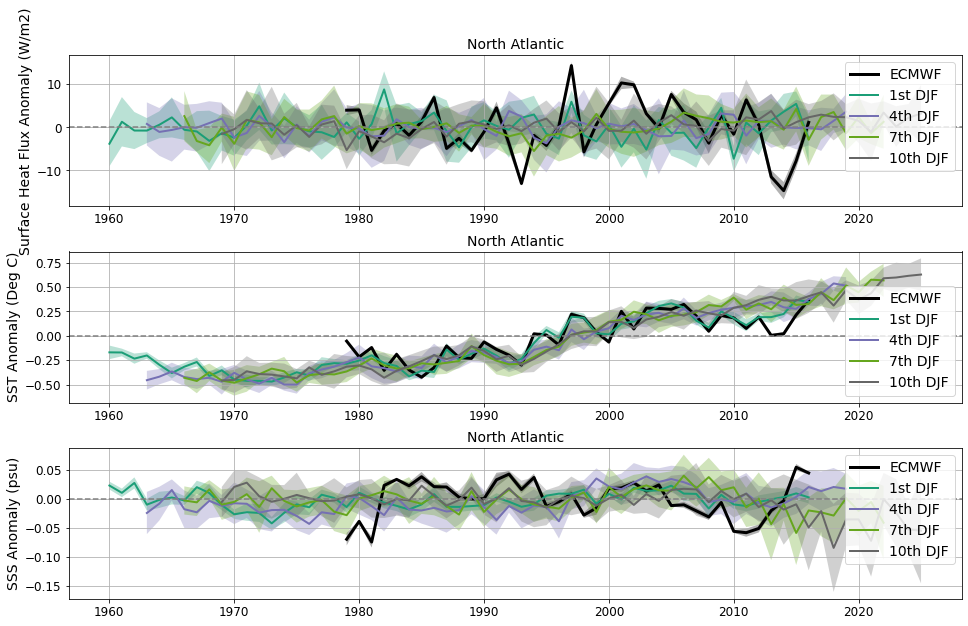

In [8]:
grid1 = plt.GridSpec(3, 1, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,10])

tmp = ds_ECMWF.sel(time_counter = ds_ECMWF['time_counter.season'] == 'DJF')
col = plt.cm.Dark2(np.linspace(0.,0.9, 10))

for var in range(0,3):
    
    ax = fig.add_subplot(grid1[var, 0])
    tmp1 = tmp['North_Atlantic'].isel(var=var)
    ax.plot(tmp['time_counter.year'], tmp1.mean('r'), lw=3, color='k')
    ax.fill_between(tmp['time_counter.year'], tmp1.mean('r') - tmp1.std('r'), 
                    tmp1.mean('r') + tmp1.std('r'), facecolor='k', alpha=0.3)
    
    for i in range(0,10,3):
        
        tmp1 = ds_DePreSys['North_Atlantic'].isel(var=var, lead_year=i)
        ax.plot(tmp1['start_year'] + 1960 + i, tmp1.mean('r'), lw=2, color=col[i])
        ax.fill_between(tmp1['start_year'] + 1960 + i, tmp1.mean('r') - tmp1.std('r'), 
                    tmp1.mean('r') + tmp1.std('r'), facecolor=col[i], alpha=0.3)
    if(var == 0):    
        ax.set_ylabel('Surface Heat Flux Anomaly (W/m2)', fontsize=14)
    elif(var == 1):
        ax.set_ylabel('SST Anomaly (Deg C)', fontsize=14)
    else:
        ax.set_ylabel('SSS Anomaly (psu)', fontsize=14)
    
    ax.set_title('North Atlantic', fontsize=14)
    ax.legend(['ECMWF', '1st DJF', '4th DJF', '7th DJF', '10th DJF'], fontsize=14)
    ax.axhline(y=0.0, color="grey", linestyle="--") 
    ax.grid('on')
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

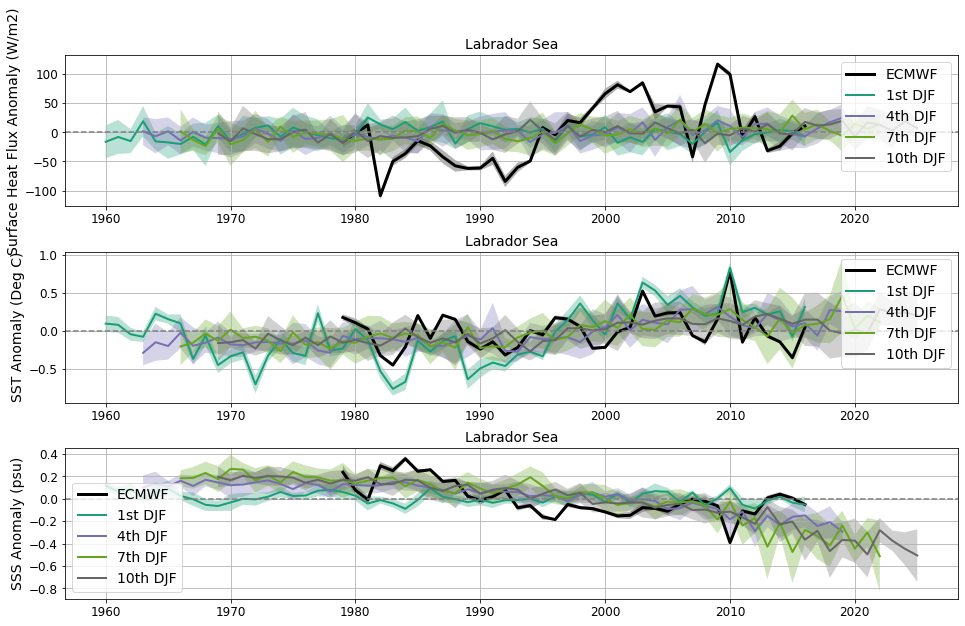

In [9]:
grid1 = plt.GridSpec(3, 1, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,10])

tmp = ds_ECMWF.sel(time_counter = ds_ECMWF['time_counter.season'] == 'DJF')
col = plt.cm.Dark2(np.linspace(0.,0.9, 10))

for var in range(0,3):
    
    ax = fig.add_subplot(grid1[var, 0])
    tmp1 = tmp['Labrador_Sea'].isel(var=var)
    ax.plot(tmp['time_counter.year'], tmp1.mean('r'), lw=3, color='k')
    ax.fill_between(tmp['time_counter.year'], tmp1.mean('r') - tmp1.std('r'), 
                    tmp1.mean('r') + tmp1.std('r'), facecolor='k', alpha=0.3)
    
    for i in range(0,10,3):
        
        tmp1 = ds_DePreSys['Labrador_Sea'].isel(var=var, lead_year=i)
        ax.plot(tmp1['start_year'] + 1960 + i, tmp1.mean('r'), lw=2, color=col[i])
        ax.fill_between(tmp1['start_year'] + 1960 + i, tmp1.mean('r') - tmp1.std('r'), 
                    tmp1.mean('r') + tmp1.std('r'), facecolor=col[i], alpha=0.3)
    if(var == 0):    
        ax.set_ylabel('Surface Heat Flux Anomaly (W/m2)', fontsize=14)
    elif(var == 1):
        ax.set_ylabel('SST Anomaly (Deg C)', fontsize=14)
    else:
        ax.set_ylabel('SSS Anomaly (psu)', fontsize=14)
        
    ax.set_title('Labrador Sea', fontsize=14)
    ax.legend(['ECMWF', '1st DJF', '4th DJF', '7th DJF', '10th DJF'], fontsize=14)
    ax.axhline(y=0.0, color="grey", linestyle="--") 
    ax.grid('on')
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

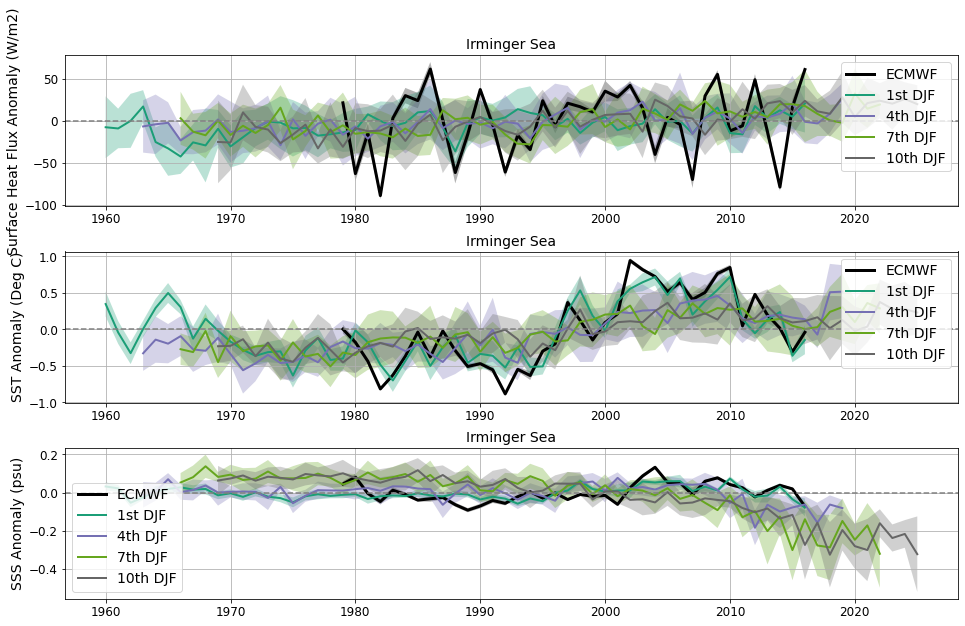

In [10]:
grid1 = plt.GridSpec(3, 1, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,10])

tmp = ds_ECMWF.sel(time_counter = ds_ECMWF['time_counter.season'] == 'DJF')
col = plt.cm.Dark2(np.linspace(0.,0.9, 10))

for var in range(0,3):
    
    ax = fig.add_subplot(grid1[var, 0])
    tmp1 = tmp['Irminger_Sea'].isel(var=var)
    ax.plot(tmp['time_counter.year'], tmp1.mean('r'), lw=3, color='k')
    ax.fill_between(tmp['time_counter.year'], tmp1.mean('r') - tmp1.std('r'), 
                    tmp1.mean('r') + tmp1.std('r'), facecolor='k', alpha=0.3)
    
    for i in range(0,10,3):
        
        tmp1 = ds_DePreSys['Irminger_Sea'].isel(var=var, lead_year=i)
        ax.plot(tmp1['start_year'] + 1960 + i, tmp1.mean('r'), lw=2, color=col[i])
        ax.fill_between(tmp1['start_year'] + 1960 + i, tmp1.mean('r') - tmp1.std('r'), 
                    tmp1.mean('r') + tmp1.std('r'), facecolor=col[i], alpha=0.3)
    if(var == 0):    
        ax.set_ylabel('Surface Heat Flux Anomaly (W/m2)', fontsize=14)
    elif(var == 1):
        ax.set_ylabel('SST Anomaly (Deg C)', fontsize=14)
    else:
        ax.set_ylabel('SSS Anomaly (psu)', fontsize=14)
        
    ax.set_title('Irminger Sea', fontsize=14)
    ax.legend(['ECMWF', '1st DJF', '4th DJF', '7th DJF', '10th DJF'], fontsize=14)
    ax.axhline(y=0.0, color="grey", linestyle="--") 
    ax.grid('on')
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)